In [16]:
import pandas as pd

In [17]:
data = pd.read_csv("./data/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv")

In [18]:
data

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
63995,10,2) $100 - $200,105.54,1,0,Urban,0,Web,Mens E-Mail,0,0,0.0
63996,5,1) $0 - $100,38.91,0,1,Urban,1,Phone,Mens E-Mail,0,0,0.0
63997,6,1) $0 - $100,29.99,1,0,Urban,1,Phone,Mens E-Mail,0,0,0.0
63998,1,5) $500 - $750,552.94,1,0,Surburban,1,Multichannel,Womens E-Mail,0,0,0.0


In [19]:
data["treatment"] = 0
data["treatment"] = data["treatment"].where(data["segment"] == "Mens E-Mail", 1)

In [20]:
data = data.drop(columns="mens")

In [21]:
data.columns

Index(['recency', 'history_segment', 'history', 'womens', 'zip_code', 'newbie',
       'channel', 'segment', 'visit', 'conversion', 'spend', 'treatment'],
      dtype='object')

In [24]:
# 疑似非RCTデータ作成

condition = (data["history"] > 300) & (data["recency"] < 6) & (data["channel"] == "Multichannel") 

not_rct_data = data.drop(data.loc[condition & (data["treatment"] == 1), :].index)
not_rct_data = data.drop(data.loc[~condition & (data["treatment"] == 0), :].index)

In [26]:
not_rct_data

,recency,history_segment,history,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment
0,10,2) $100 - $200,142.44,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0,1
1,6,3) $200 - $350,329.08,1,Rural,1,Web,No E-Mail,0,0,0.0,1
2,7,2) $100 - $200,180.65,1,Surburban,1,Web,Womens E-Mail,0,0,0.0,1
4,2,1) $0 - $100,45.34,0,Urban,0,Web,Womens E-Mail,0,0,0.0,1
5,6,2) $100 - $200,134.83,1,Surburban,0,Phone,Womens E-Mail,1,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
63989,10,3) $200 - $350,304.30,1,Surburban,0,Web,Womens E-Mail,1,0,0.0,1
63990,6,1) $0 - $100,80.02,1,Surburban,0,Phone,No E-Mail,0,0,0.0,1
63991,1,3) $200 - $350,306.10,0,Surburban,1,Phone,Womens E-Mail,0,0,0.0,1
63993,4,4) $350 - $500,374.07,1,Surburban,0,Phone,Womens E-Mail,0,0,0.0,1


In [27]:
import numpy as np
struct_data = not_rct_data.copy()

non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)
print(non_numeric_columns)

['history_segment', 'zip_code', 'channel', 'segment']


In [29]:

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])

struct_data.head(5)

,recency,history_segment,history,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment
0,10,1,142.44,0,1,0,1,2,0,0,0.0,1
1,6,2,329.08,1,0,1,2,1,0,0,0.0,1
2,7,1,180.65,1,1,1,2,2,0,0,0.0,1
4,2,0,45.34,0,2,0,2,2,0,0,0.0,1
5,6,1,134.83,1,1,0,1,2,1,0,0.0,1


<AxesSubplot:>

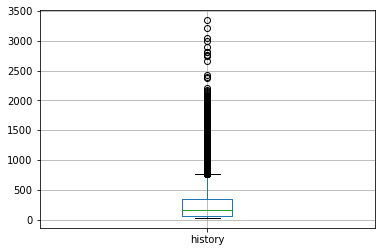

In [34]:
struct_data[["history"]].boxplot()

In [35]:
from causalnex.discretiser import Discretiser
struct_data["spend"] = Discretiser(method="fixed",
                          numeric_split_points=[100, 200, 300, 400, 500]).transform(struct_data["spend"].values)

ModuleNotFoundError: No module named 'causalnex'